<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python_IDW/IDW_basic_O3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.0 MB/s eta 0:00:00


In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 17.7 MB/s eta 0:00:00


# IDW - Additive Method

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools
from sklearn.neighbors import BallTree

# === Load CSV Data ===
csv_file_path = "baseO3nearest_grid_idw.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (Observed - Modeled)
df["bias"] = df["SURF_ppb_O3"] - df["nearest_SURF_ppb_O3"]

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_O3_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
o3_modeled = dataset.variables["SURF_ppb_O3"][0, :, :]

# Convert degrees to radians (for Haversine calculations)
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon_rad, lat_rad)
points_grid = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# Prepare Station Data (Convert to Radians)
station_lons_rad = np.radians(df["nearest_grid_lon"].values)
station_lats_rad = np.radians(df["nearest_grid_lat"].values)
station_points = np.column_stack([station_lats_rad, station_lons_rad])
bias_values = df["bias"].values

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # p (Decay Rate)
k_values = np.arange(2, 41, 1).tolist()  # k (Number of Neighbors)

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for IDW") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_values[train_index], bias_values[test_index]

            train_tree = BallTree(train_points, metric="haversine")
            predicted_bias = []

            for test_point in test_points:
                dists, idxs = train_tree.query([test_point], k=k)

                dists = dists.flatten()
                idxs = idxs.flatten()

                if np.any(dists == 0):  # Exact match case
                    predicted_bias.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)  # Inverse Distance Weighting
                    weights /= np.sum(weights)  # Normalize Weights
                    interpolated_bias = np.sum(weights * train_values[idxs])
                    predicted_bias.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_O3_Y_IDW_ADD_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW with Optimized `p` and `k` ===
def idw_inverse_distance(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.zeros(grid_points.shape[0])

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = 1 / (dists_non_zero ** p)  # Inverse Distance Weighting
    weights /= np.sum(weights, axis=1, keepdims=True)  # Normalize Weights

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Bias with Best Hyperparameters
print("\nApplying IDW (Inverse Distance Weighting) with Optimized p & k...")
interpolated_bias_idw = idw_inverse_distance(points_grid, station_points, bias_values, best_params[0], best_params[1])
interpolated_bias_idw = interpolated_bias_idw.reshape(o3_modeled.shape)

# === Save Bias Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_O3_Y_IDW_ADD.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_var = new_dataset.createVariable("Interpolated_Bias", "f4", ("lat", "lon"))

bias_var.setncatts(dataset.variables["SURF_ppb_O3"].__dict__)
new_dataset.description = "Interpolated Bias using Inverse Distance Weighting (Optimized p & k, No Time Dimension, Haversine BallTree)"

lat_var[:] = lat
lon_var[:] = lon
bias_var[:, :] = interpolated_bias_idw

new_dataset.close()
print("Interpolated Bias Saved to:", bias_netcdf_path)

# === Compute Leave-One-Station-Out (LOSO) RMSE for the Best Model ===
print("\nComputing Leave-One-Station-Out (LOSO) RMSE for the best model...")

loso_predictions = []
loso_actuals = []

for i in tqdm(range(len(station_points)), desc="LOSO Progress"):
    # Leave one station out
    train_points = np.delete(station_points, i, axis=0)
    train_values = np.delete(bias_values, i)

    # Create BallTree with remaining stations
    train_tree = BallTree(train_points, metric="haversine")
    test_point = station_points[i].reshape(1, -1)

    # Find k nearest neighbors
    dists, idxs = train_tree.query(test_point, k=best_params[1])

    dists = dists.flatten()
    idxs = idxs.flatten()

    if np.any(dists == 0):  # Exact match case
        predicted_bias = train_values[idxs[dists == 0]][0]
    else:
        weights = 1 / (dists ** best_params[0])  # Inverse Distance Weighting
        weights /= np.sum(weights)  # Normalize Weights
        predicted_bias = np.sum(weights * train_values[idxs])

    loso_predictions.append(predicted_bias)
    loso_actuals.append(bias_values[i])

# Compute LOSO RMSE
loso_rmse = np.sqrt(mean_squared_error(loso_actuals, loso_predictions))
print(f"\nLOSO RMSE for best model (p={best_params[0]}, k={best_params[1]}): {loso_rmse:.4f}")

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


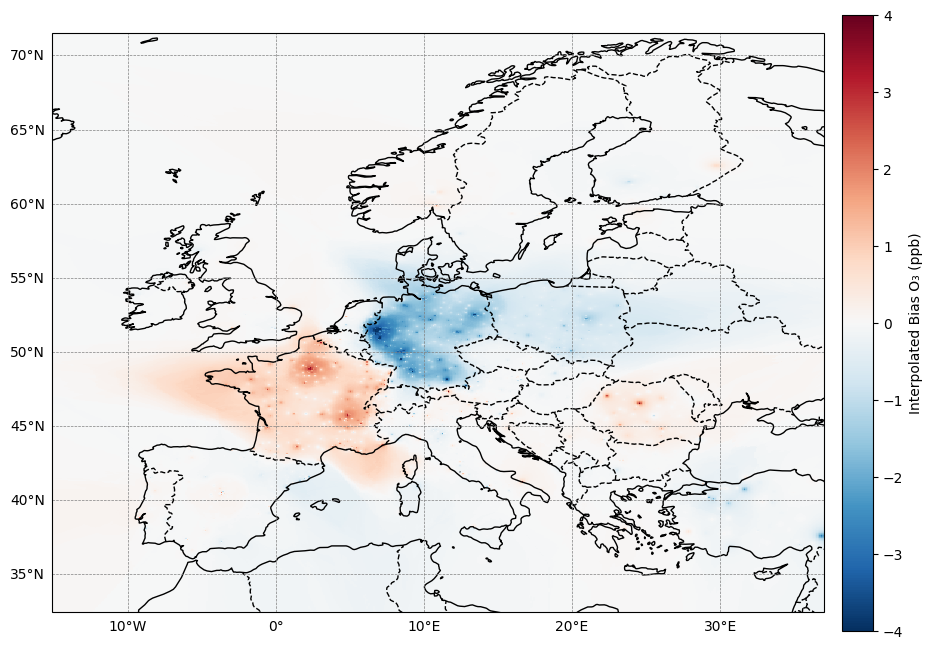

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "Add/BaseCase_O3_Y_IDW_ADD.nc"  # Updated file name
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias (residuals)
interpolated_bias = ds_bias["Interpolated_Bias"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -4  # Minimum bias value for color scale (adjust if needed)
cbar_max = 4 # Maximum bias value for color scale (adjust if needed)

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias
im = ax.pcolormesh(lon, lat, interpolated_bias, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias O₃ (ppb)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()



In [4]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_O3_YEARLY.nc"
bias_nc_path = "Add/BaseCase_O3_Y_IDW_ADD.nc"
corrected_nc_path = "Add/BaseCase_Corrected_O3_Y_IDW_ADD.nc"

# === Load the Original Modeled O₃ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    o3_original = original_nc.variables["SURF_ppb_O3"][:]

    # Load the interpolated bias
    interpolated_bias = bias_nc.variables["Interpolated_Bias"][:]

    # === Compute the Unbiased O₃ ===
    o3_corrected = o3_original + interpolated_bias  # Apply the bias correction

    # === Save the Corrected O₃ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        o3_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original O₃ variable
        o3_var.setncatts(original_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        o3_var[:] = o3_corrected  # Store corrected O₃

print(" Bias correction completed successfully!")
print(" Corrected O₃ NetCDF file saved as:", corrected_nc_path)

 Bias correction completed successfully!
 Corrected O₃ NetCDF file saved as: Add/BaseCase_Corrected_O3_Y_IDW_ADD.nc


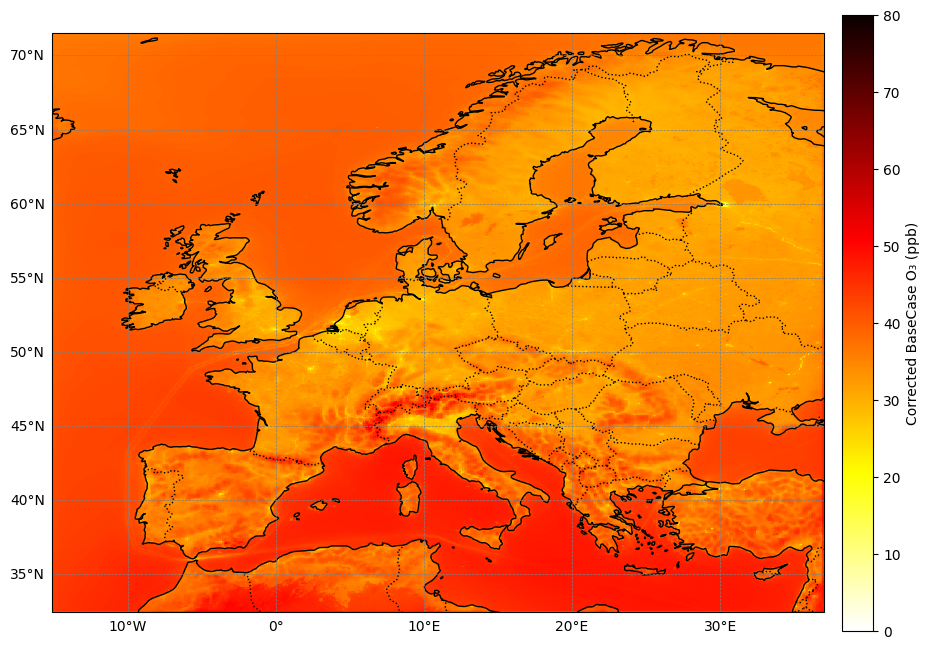

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected O₃ NetCDF File ===
corrected_netcdf_path = "Add/BaseCase_Corrected_O3_Y_IDW_ADD.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Log scale between 1 and max value (adjust if needed)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the O₃ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected BaseCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


In [6]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
perturbed_scenario_nc_path = "SCEN_PERT_O3_YEARLY.nc"  # Perturbed scenario NetCDF
interpolated_residual_nc_path = "Add/BaseCase_O3_Y_IDW_ADD.nc"  # Interpolated residuals NetCDF
base_corrected_nc_path = "Add/BaseCase_Corrected_O3_Y_IDW_ADD.nc"  # Base case corrected NetCDF
corrected_scenario_nc_path = "Add/Scenario_Corrected_O3_Y_IDW_ADD.nc"  # Output corrected scenario NetCDF

# === Load NetCDF Data ===
with nc.Dataset(perturbed_scenario_nc_path, "r") as pert_nc, \
     nc.Dataset(interpolated_residual_nc_path, "r") as res_nc, \
     nc.Dataset(base_corrected_nc_path, "r") as base_nc:

    # Load variables
    lon = pert_nc.variables["lon"][:]
    lat = pert_nc.variables["lat"][:]
    time = pert_nc.variables["time"][:]
    scenario_perturb = pert_nc.variables["SURF_ppb_O3"][:]

    interpolated_residual = res_nc.variables["Interpolated_Bias"][:]
    base_corrected = base_nc.variables["SURF_ppb_O3_corrected"][:]

    # === Compute the Unbiased Scenario ===
    scenario_corrected = scenario_perturb * (1 + interpolated_residual / base_corrected)

    # === Save the Corrected Scenario to a New NetCDF File ===
    with nc.Dataset(corrected_scenario_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        scenario_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original variable
        scenario_var.setncatts(pert_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        scenario_var[:] = scenario_corrected  # Store corrected scenario

print(" Scenario Bias Correction Completed Successfully!")
print(" Corrected O₃ Scenario NetCDF file saved as:", corrected_scenario_nc_path)

 Scenario Bias Correction Completed Successfully!
 Corrected O₃ Scenario NetCDF file saved as: Add/Scenario_Corrected_O3_Y_IDW_ADD.nc


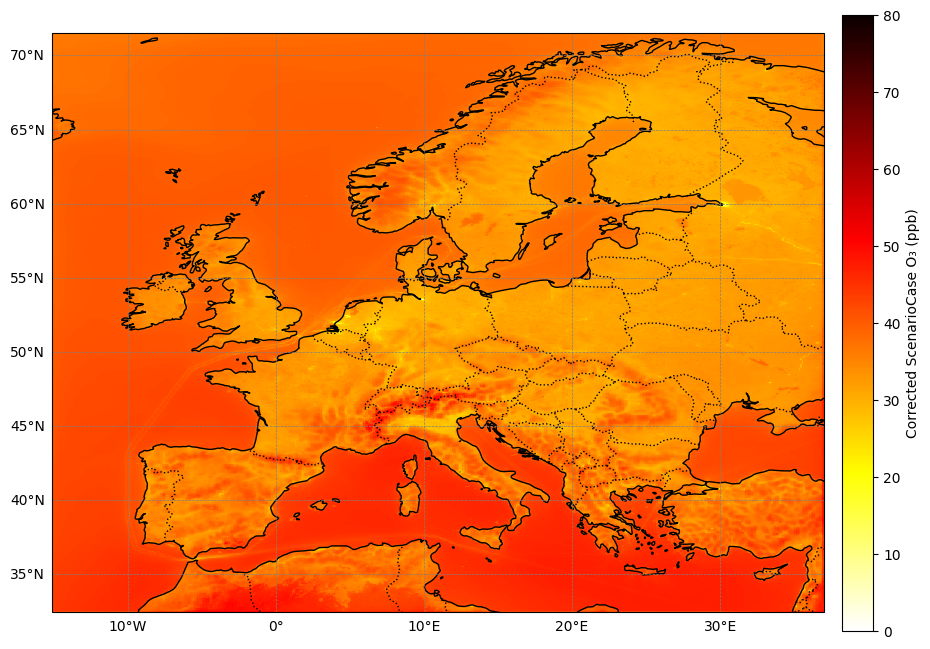

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected Scenario O₃ NetCDF File ===
corrected_netcdf_path = "Add/Scenario_Corrected_O3_Y_IDW_ADD.nc"  # Adjust path if needed
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ scenario values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Adjust scale if needed

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the corrected O₃ scenario using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected ScenarioCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()

# IDW - Rescaled Additive Method

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools
from sklearn.neighbors import BallTree

# === Load CSV Data ===
csv_file_path = "baseO3nearest_grid_idw.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias (Observed - Modeled)
df["bias"] = df["SURF_ppb_O3"] - df["nearest_SURF_ppb_O3"]

# === Rescale Bias (Using Standard Deviation) ===
bias_std = np.std(df["bias"])  # Compute Standard Deviation
df["bias_rescaled"] = df["bias"] / bias_std  # Rescale Bias

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_O3_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
o3_modeled = dataset.variables["SURF_ppb_O3"][0, :, :]

# Convert degrees to radians (for Haversine calculations)
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon_rad, lat_rad)
points_grid = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# Prepare Station Data (Convert to Radians)
station_lons_rad = np.radians(df["nearest_grid_lon"].values)
station_lats_rad = np.radians(df["nearest_grid_lat"].values)
station_points = np.column_stack([station_lats_rad, station_lons_rad])
bias_rescaled_values = df["bias_rescaled"].values  # Use Rescaled Bias

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # Decay Rate
k_values = np.arange(2, 41, 1).tolist()  # Number of Neighbors

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for IDW Rescaled Additive") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_rescaled_values[train_index], bias_rescaled_values[test_index]

            train_tree = BallTree(train_points, metric="haversine")
            predicted_bias_rescaled = []

            for test_point in test_points:
                dists, idxs = train_tree.query([test_point], k=k)

                dists = dists.flatten()
                idxs = idxs.flatten()

                if np.any(dists == 0):  # Exact match case
                    predicted_bias_rescaled.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)  # Inverse Distance Weighting
                    weights /= np.sum(weights)  # Normalize Weights
                    interpolated_bias = np.sum(weights * train_values[idxs])
                    predicted_bias_rescaled.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias_rescaled))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_O3_Y_IDW_RESCALED_ADD_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW with Optimized `p` and `k` ===
def idw_inverse_distance(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.zeros(grid_points.shape[0])

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = 1 / (dists_non_zero ** p)  # Inverse Distance Weighting
    weights /= np.sum(weights, axis=1, keepdims=True)  # Normalize Weights

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Rescaled Bias with Best Hyperparameters
print("\nApplying IDW Rescaled Additive with Optimized p & k...")
interpolated_bias_rescaled = idw_inverse_distance(points_grid, station_points, bias_rescaled_values, best_params[0], best_params[1])
interpolated_bias_rescaled = interpolated_bias_rescaled.reshape(o3_modeled.shape)

# === Convert Back to Original Scale ===
interpolated_bias_final = interpolated_bias_rescaled * bias_std

# === Save Bias Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_O3_Y_IDW_RESCALED_ADD.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_var = new_dataset.createVariable("Interpolated_Bias", "f4", ("lat", "lon"))

bias_var.setncatts(dataset.variables["SURF_ppb_O3"].__dict__)
new_dataset.description = "Interpolated Bias using Rescaled IDW Additive (Optimized p & k, No Time Dimension, Haversine BallTree)"

lat_var[:] = lat
lon_var[:] = lon
bias_var[:, :] = interpolated_bias_final  # Store the final bias

new_dataset.close()
print("Interpolated Rescaled Bias Saved to:", bias_netcdf_path)

# === Compute Leave-One-Station-Out (LOSO) RMSE for the Best Model ===
print("\nComputing Leave-One-Station-Out (LOSO) RMSE for the best model...")

loso_predictions = []
loso_actuals = []

for i in tqdm(range(len(station_points)), desc="LOSO Progress"):
    # Leave one station out
    train_points = np.delete(station_points, i, axis=0)
    train_values = np.delete(bias_rescaled_values, i)

    # Create BallTree with remaining stations
    train_tree = BallTree(train_points, metric="haversine")
    test_point = station_points[i].reshape(1, -1)

    # Find k nearest neighbors
    dists, idxs = train_tree.query(test_point, k=best_params[1])

    dists = dists.flatten()
    idxs = idxs.flatten()

    if np.any(dists == 0):  # Exact match case
        predicted_bias = train_values[idxs[dists == 0]][0]
    else:
        weights = 1 / (dists ** best_params[0])  # Inverse Distance Weighting
        weights /= np.sum(weights)  # Normalize Weights
        predicted_bias = np.sum(weights * train_values[idxs])

    loso_predictions.append(predicted_bias)
    loso_actuals.append(bias_rescaled_values[i])

# Compute LOSO RMSE
loso_rmse = np.sqrt(mean_squared_error(loso_actuals, loso_predictions))
print(f"\nLOSO RMSE for best model (p={best_params[0]}, k={best_params[1]}): {loso_rmse:.4f}")


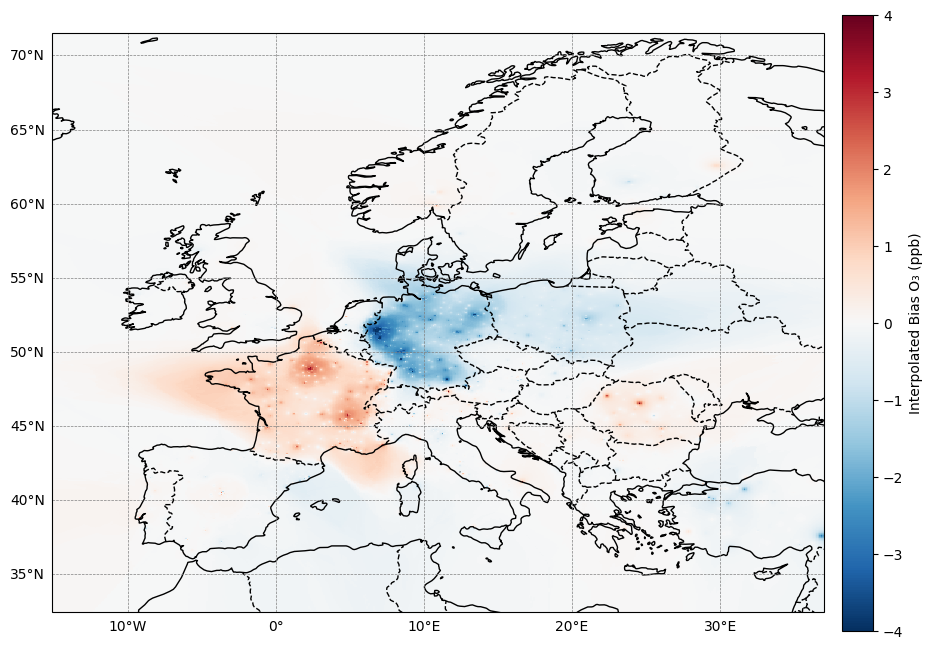

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "Resc/BaseCase_O3_Y_IDW_RESCALED_ADD.nc"  # Updated file name
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias (residuals)
interpolated_bias = ds_bias["Interpolated_Bias"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -4  # Minimum bias value for color scale (adjust if needed)
cbar_max = 4 # Maximum bias value for color scale (adjust if needed)

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias
im = ax.pcolormesh(lon, lat, interpolated_bias, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias O₃ (ppb)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()

In [10]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_O3_YEARLY.nc"  # Original modeled O₃
bias_nc_path = "Resc/BaseCase_O3_Y_IDW_RESCALED_ADD.nc"  # Interpolated bias NetCDF
corrected_nc_path = "Resc/BaseCase_Corrected_O3_Y_IDW_RESCALED_ADD.nc"  # Output corrected NetCDF

# === Load the Original Modeled O₃ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    o3_original = original_nc.variables["SURF_ppb_O3"][:]

    # Load the interpolated bias
    interpolated_bias = bias_nc.variables["Interpolated_Bias"][:]

    # === Compute the Unbiased O₃ ===
    o3_corrected = o3_original + interpolated_bias  # Apply additive bias correction

    # === Save the Corrected O₃ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        o3_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original O₃ variable
        o3_var.setncatts(original_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        o3_var[:] = o3_corrected  # Store corrected O₃

print(" Bias Correction Completed Successfully!")
print(" Corrected O₃ NetCDF file saved as:", corrected_nc_path)

 Bias Correction Completed Successfully!
 Corrected O₃ NetCDF file saved as: Resc/BaseCase_Corrected_O3_Y_IDW_RESCALED_ADD.nc


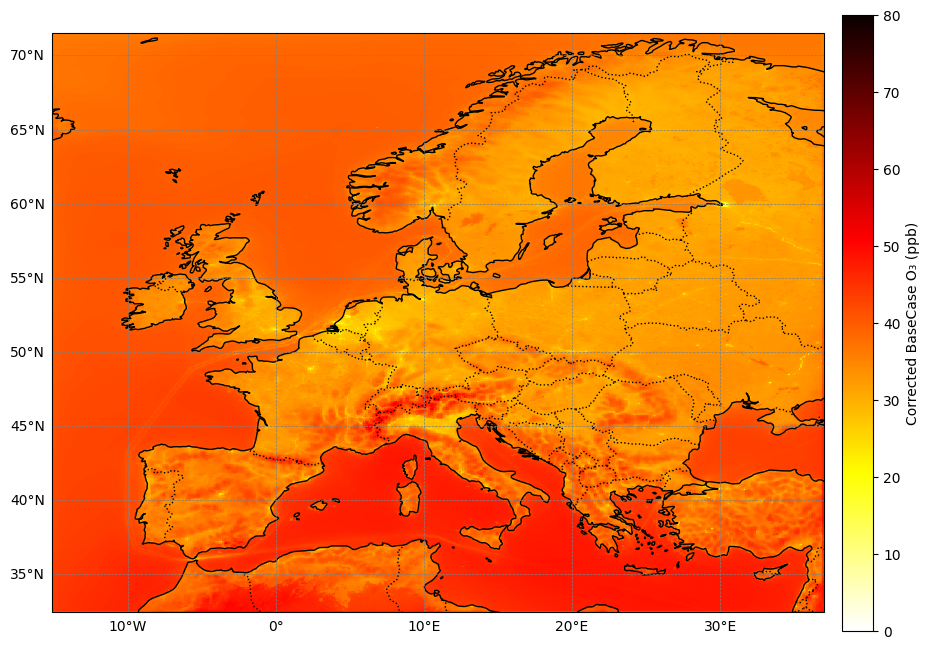

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected O₃ NetCDF File ===
corrected_netcdf_path = "Add/BaseCase_Corrected_O3_Y_IDW_ADD.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Log scale between 1 and max value (adjust if needed)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the O₃ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected BaseCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()



In [12]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
perturbed_scenario_nc_path = "SCEN_PERT_O3_YEARLY.nc"  # Perturbed scenario NetCDF
interpolated_residual_nc_path = "Resc/BaseCase_O3_Y_IDW_RESCALED_ADD.nc"  # Interpolated residuals NetCDF
base_corrected_nc_path = "Resc/BaseCase_Corrected_O3_Y_IDW_RESCALED_ADD.nc"  # Base case corrected NetCDF
corrected_scenario_nc_path = "Resc/Scenario_Corrected_O3_Y_IDW_RESCALED_ADD.nc"  # Output corrected scenario NetCDF

# === Load NetCDF Data ===
with nc.Dataset(perturbed_scenario_nc_path, "r") as pert_nc, \
     nc.Dataset(interpolated_residual_nc_path, "r") as res_nc, \
     nc.Dataset(base_corrected_nc_path, "r") as base_nc:

    # Load variables
    lon = pert_nc.variables["lon"][:]
    lat = pert_nc.variables["lat"][:]
    time = pert_nc.variables["time"][:]
    scenario_perturb = pert_nc.variables["SURF_ppb_O3"][:]

    interpolated_residual = res_nc.variables["Interpolated_Bias"][:]
    base_corrected = base_nc.variables["SURF_ppb_O3_corrected"][:]

    # === Compute the Unbiased Scenario ===
    scenario_corrected = scenario_perturb * (1 + interpolated_residual / base_corrected)

    # === Save the Corrected Scenario to a New NetCDF File ===
    with nc.Dataset(corrected_scenario_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        scenario_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original variable
        scenario_var.setncatts(pert_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        scenario_var[:] = scenario_corrected  # Store corrected scenario

print(" Scenario Bias Correction Completed Successfully!")
print(" Corrected O₃ Scenario NetCDF file saved as:", corrected_scenario_nc_path)



 Scenario Bias Correction Completed Successfully!
 Corrected O₃ Scenario NetCDF file saved as: Resc/Scenario_Corrected_O3_Y_IDW_RESCALED_ADD.nc


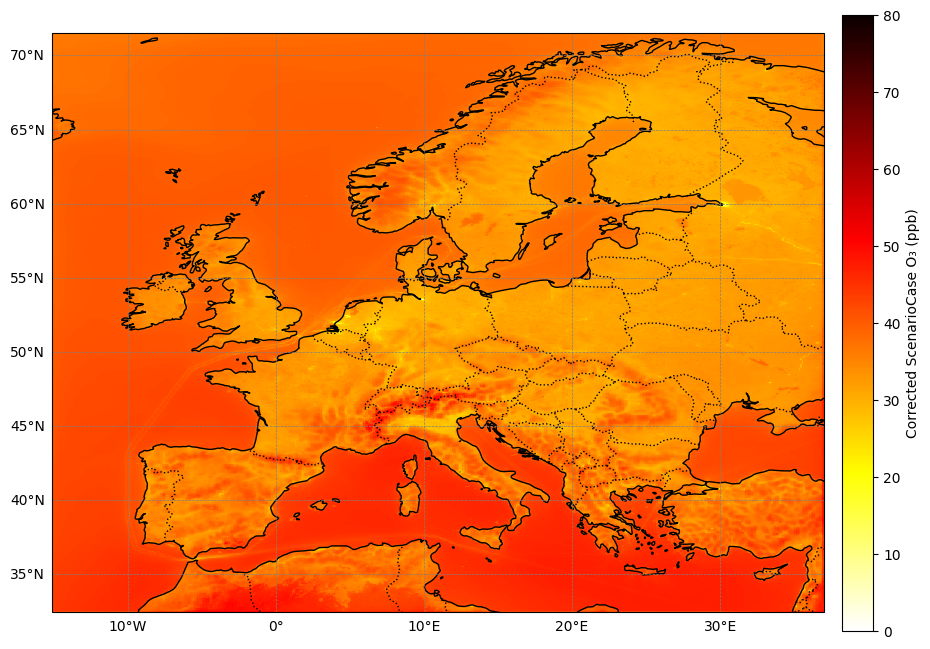

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected Scenario O₃ NetCDF File ===
corrected_netcdf_path = "Add/Scenario_Corrected_O3_Y_IDW_ADD.nc"  # Adjust path if needed
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ scenario values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Adjust scale if needed

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the corrected O₃ scenario using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected ScenarioCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()



# IDW - Multiplicative Mehod

In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.neighbors import BallTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Load CSV Data ===
csv_file_path = "baseO3nearest_grid_idw.csv"
df = pd.read_csv(csv_file_path)

# Compute bias ratio (Observed / Modeled)
df["bias_ratio"] = df["SURF_ppb_O3"] / df["nearest_SURF_ppb_O3"]

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_O3_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
o3_modeled = dataset.variables["SURF_ppb_O3"][0, :, :]

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([np.radians(lat_mesh.ravel()), np.radians(lon_mesh.ravel())])  # Convert to radians for BallTree

# Prepare Station Data
station_points = np.column_stack([np.radians(df["nearest_grid_lat"].values), np.radians(df["nearest_grid_lon"].values)])  # Convert to radians
bias_ratios = df["bias_ratio"].values

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # p (Power Parameter)
k_values = np.arange(2, 41, 1).tolist()  # k (Number of Neighbors)

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for IDW Multiplicative (Inverse Distance)") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_ratios[train_index], bias_ratios[test_index]

            train_tree = BallTree(train_points, metric="haversine")  # Use BallTree with Haversine distance
            dists, idxs = train_tree.query(test_points, k=k)

            predicted_bias_ratio = []
            for i in range(len(test_points)):
                if np.any(dists[i] == 0):
                    predicted_bias_ratio.append(train_values[idxs[i][dists[i] == 0]][0])
                else:
                    weights = 1 / (dists[i] ** p)  # Inverse Distance Weighting
                    weights /= np.sum(weights)  # Normalize Weights
                    interpolated_ratio = np.sum(weights * train_values[idxs[i]])
                    predicted_bias_ratio.append(interpolated_ratio)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias_ratio))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_O3_Y_IDW_MUL_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW Multiplicative with Optimized `p` and `k` ===
def idw_inverse_multiplicative(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")  # Use BallTree with Haversine distance
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.ones(grid_points.shape[0])  # Initialize with 1 (Multiplicative method)

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = 1 / (dists_non_zero ** p)  # Inverse Distance Weighting
    weights /= np.sum(weights, axis=1, keepdims=True)  # Normalize Weights

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Bias Ratio with Best Hyperparameters
print("\nApplying IDW Multiplicative with Optimized p & k (BallTree)...")
interpolated_ratio_idw = idw_inverse_multiplicative(points_grid, station_points, bias_ratios, best_params[0], best_params[1])
interpolated_ratio_idw = interpolated_ratio_idw.reshape(o3_modeled.shape)

# === Save Bias Ratio Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_O3_Y_IDW_MUL.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_ratio_var = new_dataset.createVariable("Interpolated_Bias_Ratio", "f4", ("lat", "lon"))

bias_ratio_var.setncatts(dataset.variables["SURF_ppb_O3"].__dict__)
new_dataset.description = "Interpolated Bias Ratio using Inverse Distance Weighting Multiplicative (Optimized p & k, No Time Dimension, BallTree with Haversine)"

lat_var[:] = lat
lon_var[:] = lon
bias_ratio_var[:, :] = interpolated_ratio_idw

new_dataset.close()
print("Interpolated Bias Ratio Saved to:", bias_netcdf_path)

# === Compute Leave-One-Station-Out (LOSO) RMSE for the Best Model ===
print("\nComputing Leave-One-Station-Out (LOSO) RMSE for the best model...")

loso_predictions = []
loso_actuals = []

for i in tqdm(range(len(station_points)), desc="LOSO Progress"):
    # Leave one station out
    train_points = np.delete(station_points, i, axis=0)
    train_values = np.delete(bias_ratios, i)

    # Create BallTree with remaining stations
    train_tree = BallTree(train_points, metric="haversine")
    test_point = station_points[i].reshape(1, -1)

    # Find k nearest neighbors
    dists, idxs = train_tree.query(test_point, k=best_params[1])

    dists = dists.flatten()
    idxs = idxs.flatten()

    if np.any(dists == 0):  # Exact match case
        predicted_bias = train_values[idxs[dists == 0]][0]
    else:
        weights = 1 / (dists ** best_params[0])  # Inverse Distance Weighting
        weights /= np.sum(weights)  # Normalize Weights
        predicted_bias = np.sum(weights * train_values[idxs])

    loso_predictions.append(predicted_bias)
    loso_actuals.append(bias_ratios[i])

# Compute LOSO RMSE
loso_rmse = np.sqrt(mean_squared_error(loso_actuals, loso_predictions))
print(f"\nLOSO RMSE for best model (p={best_params[0]}, k={best_params[1]}): {loso_rmse:.4f}")


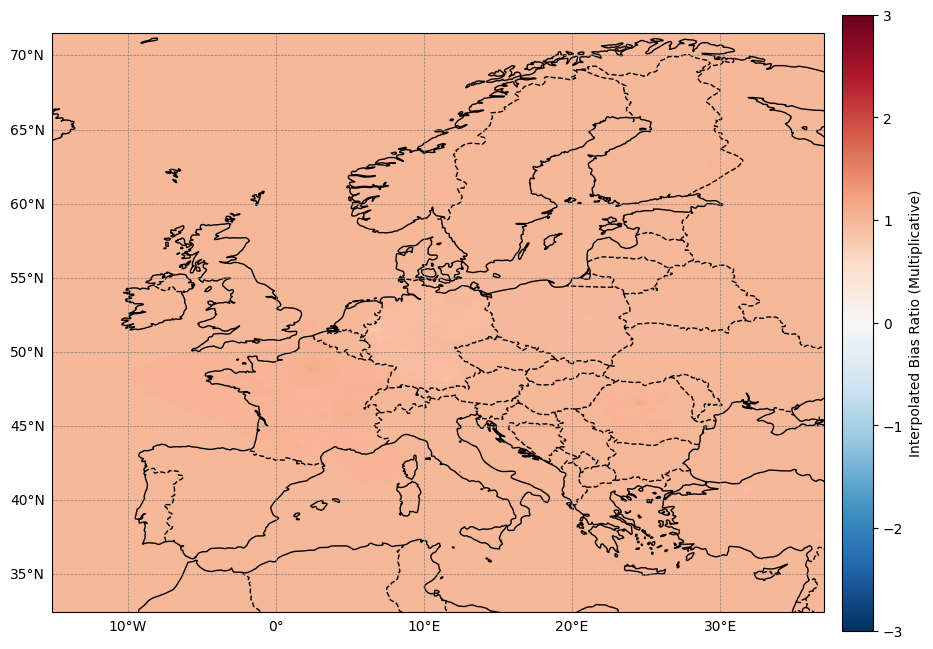

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias Ratio NetCDF File ===
bias_netcdf_path = "Mul/BaseCase_O3_Y_IDW_MUL.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias ratio
interpolated_bias_ratio = ds_bias["Interpolated_Bias_Ratio"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -3 # Set minimum scale for bias ratio
cbar_max = 3 # Set maximum scale for bias ratio

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias ratio
im = ax.pcolormesh(lon, lat, interpolated_bias_ratio, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias Ratio (Multiplicative)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()


In [16]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_O3_YEARLY.nc"
bias_ratio_nc_path = "Mul/BaseCase_O3_Y_IDW_MUL.nc"
corrected_nc_path = "Mul/BaseCase_Corrected_O3_Y_MUL.nc"

# === Load the Original Modeled O₃ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_ratio_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    o3_original = original_nc.variables["SURF_ppb_O3"][:]

    # Load the interpolated bias ratio
    interpolated_bias_ratio = bias_nc.variables["Interpolated_Bias_Ratio"][:]

    # === Apply Multiplicative Bias Correction ===
    # Ensure bias ratio does not contain values too close to zero
    min_bias_threshold = 0.1  # Prevent extreme scaling
    interpolated_bias_ratio = np.maximum(interpolated_bias_ratio, min_bias_threshold)

    # Correct O₃
    o3_corrected = o3_original * interpolated_bias_ratio  # Multiplicative correction

    # === Save the Corrected O₃ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        o3_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original O₃ variable
        o3_var.setncatts(original_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        o3_var[:] = o3_corrected  # Store corrected O₃

print(" Multiplicative Bias Correction Completed Successfully!")
print(" Corrected O₃ NetCDF file saved as:", corrected_nc_path)


 Multiplicative Bias Correction Completed Successfully!
 Corrected O₃ NetCDF file saved as: Mul/BaseCase_Corrected_O3_Y_MUL.nc


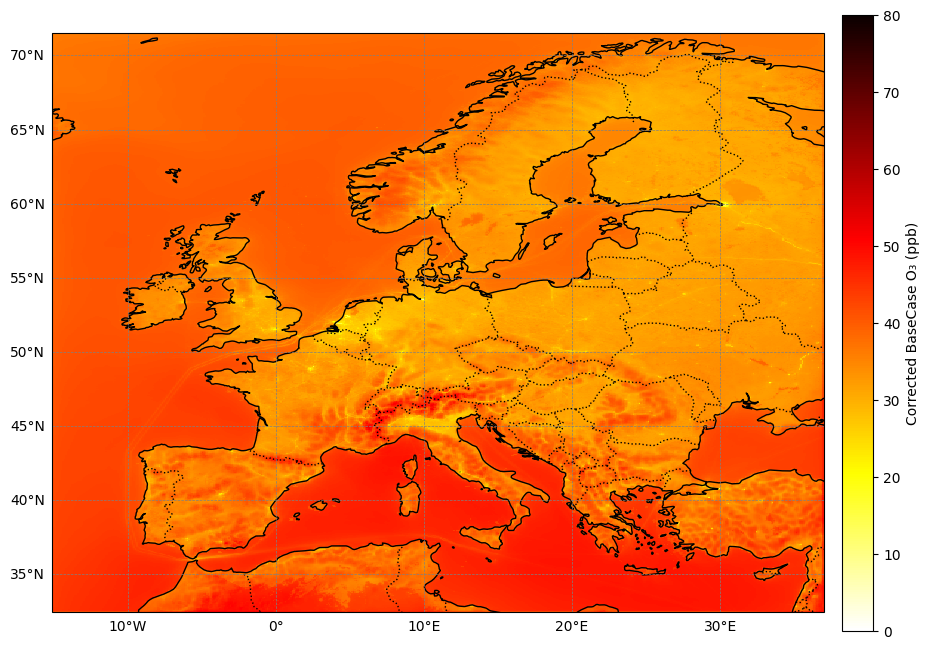

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected O₃ NetCDF File ===
corrected_netcdf_path = "Mul/BaseCase_Corrected_O3_Y_MUL.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Log scale between 1 and max value (adjust if needed)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the O₃ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected BaseCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


In [18]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
scenario_perturbed_nc_path = "SCEN_PERT_O3_YEARLY.nc"  # Perturbed Scenario NetCDF
base_corrected_nc_path = "Mul/BaseCase_Corrected_O3_Y_MUL.nc"  # Corrected Base NetCDF
bias_residual_nc_path = "Mul/BaseCase_O3_Y_IDW_MUL.nc"  # Interpolated Residuals NetCDF
corrected_scenario_nc_path = "Mul/Scenario_Corrected_O3_MUL.nc"  # Output Corrected Scenario NetCDF

# === Load NetCDF Files ===
with nc.Dataset(scenario_perturbed_nc_path, "r") as scen_nc, \
     nc.Dataset(base_corrected_nc_path, "r") as base_nc, \
     nc.Dataset(bias_residual_nc_path, "r") as bias_nc:

    # Load model grid & O₃ data
    lon = scen_nc.variables["lon"][:]
    lat = scen_nc.variables["lat"][:]
    time = scen_nc.variables["time"][:]

    o3_scenario_perturbed = scen_nc.variables["SURF_ppb_O3"][:]  # Perturbed Scenario O₃
    o3_base_corrected = base_nc.variables["SURF_ppb_O3_corrected"][:]  # Corrected Base O₃
    interpolated_residuals = bias_nc.variables["Interpolated_Bias_Ratio"][:]  # Interpolated Bias Residuals

    # === Compute the Unbiased Scenario ===
    correction_factor = 1 + (interpolated_residuals / o3_base_corrected)
    o3_scenario_corrected = o3_scenario_perturbed * correction_factor  # Apply correction

    # === Save the Corrected Scenario to a New NetCDF File ===
    with nc.Dataset(corrected_scenario_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        o3_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy metadata attributes from the original scenario file
        o3_var.setncatts(scen_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        o3_var[:] = o3_scenario_corrected  # Store corrected scenario O₃

print(" Multiplicative IDW Bias Correction Applied Successfully!")
print(" Corrected Scenario NetCDF saved as:", corrected_scenario_nc_path)



 Multiplicative IDW Bias Correction Applied Successfully!
 Corrected Scenario NetCDF saved as: Mul/Scenario_Corrected_O3_MUL.nc


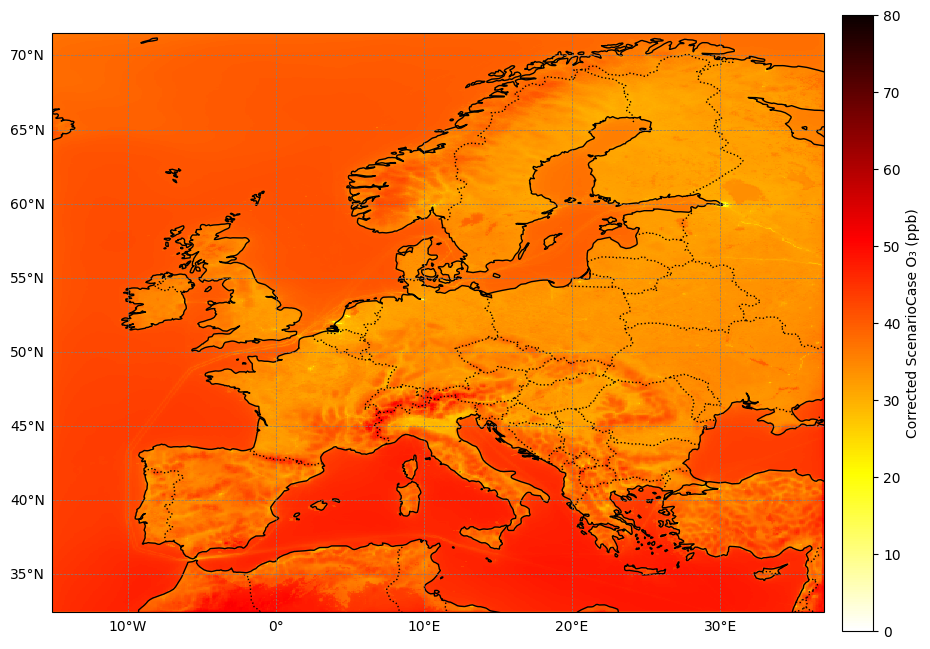

In [19]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected Scenario O₃ NetCDF File ===
corrected_netcdf_path = "Mul/Scenario_Corrected_O3_MUL.nc"  # Adjust path if needed
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ scenario values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Adjust scale if needed

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the corrected O₃ scenario using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected ScenarioCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()

